# 2. Détection d'Anomalies - CAC40

## 1. Importation des bibliothèques et chargement des données


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.2.6


In [3]:
# Load cleaned datasets
print("Loading cleaned datasets...")

# Load CAC40 cleaned data
try:
    cac40_df = pd.read_parquet('cac40_cleaned.parquet')
    print(f"CAC40 dataset loaded: {cac40_df.shape[0]} rows, {cac40_df.shape[1]} columns")
    print(f"Date range: {cac40_df['Date'].min()} to {cac40_df['Date'].max()}")
except FileNotFoundError:
    print("cac40_cleaned.parquet not found. Loading from original CSV...")
    cac40_df = pd.read_csv('cac40.csv')
    # Apply basic cleaning if parquet not available
    cac40_df.columns = cac40_df.columns.str.strip()
    cac40_df['Date'] = pd.to_datetime(cac40_df['Date'])
    # Convert numeric columns
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in cac40_df.columns:
            cac40_df[col] = cac40_df[col].astype(str).str.replace('[€$,]', '', regex=True)
            cac40_df[col] = pd.to_numeric(cac40_df[col], errors='coerce')
    cac40_df = cac40_df.dropna().sort_values('Date').reset_index(drop=True)
    print(f"CAC40 dataset loaded and cleaned: {cac40_df.shape[0]} rows")

# Load STOXX cleaned data
try:
    sto_df = pd.read_parquet('sto.parquet')    # Apply basic cleaning
    sto_df = sto_df.iloc[1:]  # Remove header row
    sto_df['Date'] = pd.to_datetime(sto_df['Date'], origin='1969-12-31', unit='D')
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in sto_df.columns:
            sto_df[col] = pd.to_numeric(sto_df[col], errors='coerce')
    sto_df = sto_df.dropna().sort_values('Date').reset_index(drop=True)
    print(f"STOXX dataset loaded and cleaned: {sto_df.shape[0]} rows")
except FileNotFoundError:
    print("sto.parquet not found.")


print("\nDatasets loaded successfully!")
print(f"CAC40 shape: {cac40_df.shape}")
print(f"STOXX shape: {sto_df.shape}")


Loading cleaned datasets...
CAC40 dataset loaded: 488 rows, 6 columns
Date range: 2023-01-02 00:00:00 to 2025-01-01 00:00:00
STOXX dataset loaded and cleaned: 699 rows

Datasets loaded successfully!
CAC40 shape: (488, 6)
STOXX shape: (699, 6)


## 2. Préparation des données pour l'analyse d'anomalies


In [4]:
# Calculate daily returns and other derived metrics
print("Calculating derived metrics...")

# Daily returns
cac40_df['Daily_Return'] = cac40_df['Close'].pct_change()

# Price range (High - Low)
cac40_df['Price_Range'] = cac40_df['High'] - cac40_df['Low']

# Volume change
cac40_df['Volume_Change'] = cac40_df['Volume'].pct_change()

# Volatility (rolling standard deviation of returns)
window = 20  # 20 trading days ≈ 1 month
cac40_df['Volatility'] = cac40_df['Daily_Return'].rolling(window=window).std()

# Moving averages
cac40_df['MA_20'] = cac40_df['Close'].rolling(window=window).mean()
cac40_df['MA_50'] = cac40_df['Close'].rolling(window=50).mean()

# Price deviation from moving average
cac40_df['Price_Deviation'] = (cac40_df['Close'] - cac40_df['MA_20']) / cac40_df['MA_20']

print(f"Derived metrics calculated for {len(cac40_df)} rows")
print(f"Date range: {cac40_df['Date'].min().strftime('%Y-%m-%d')} to {cac40_df['Date'].max().strftime('%Y-%m-%d')}")

# Display basic statistics
print("\nBasic Statistics:")
print(f"Average daily return: {cac40_df['Daily_Return'].mean():.4f}")
print(f"Daily return volatility: {cac40_df['Daily_Return'].std():.4f}")
print(f"Min daily return: {cac40_df['Daily_Return'].min():.4f}")
print(f"Max daily return: {cac40_df['Daily_Return'].max():.4f}")
print(f"Average volume: {cac40_df['Volume'].mean():,.0f}")
print(f"Average volatility (20d): {cac40_df['Volatility'].mean():.4f}")


Calculating derived metrics...
Derived metrics calculated for 488 rows
Date range: 2023-01-02 to 2025-01-01

Basic Statistics:
Average daily return: 0.0682
Daily return volatility: 0.8166
Min daily return: -0.9900
Max daily return: 9.0304
Average volume: 560,142
Average volatility (20d): 0.2584


## 3. Méthode 1: Z-Score (Détection Statistique)


In [5]:
def calculate_zscore_anomalies(data, column, threshold=3):
    """
    Calculate Z-score anomalies for a given column
    
    Parameters:
    - data: DataFrame
    - column: column name to analyze
    - threshold: Z-score threshold (default: 3)
    
    Returns:
    - DataFrame with anomaly flags and Z-scores
    """
    # Calculate Z-scores
    mean_val = data[column].mean()
    std_val = data[column].std()
    z_scores = (data[column] - mean_val) / std_val
    
    # Identify anomalies
    anomalies = abs(z_scores) > threshold
    
    return z_scores, anomalies

# Apply Z-score detection to different metrics
print("=== Z-Score Anomaly Detection ===")

# Daily returns anomalies
cac40_df['Return_ZScore'], cac40_df['Return_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'Daily_Return', threshold=3)

# Volume anomalies
cac40_df['Volume_ZScore'], cac40_df['Volume_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'Volume', threshold=3)

# Price anomalies for all price columns
cac40_df['Open_ZScore'], cac40_df['Open_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'Open', threshold=3)
cac40_df['High_ZScore'], cac40_df['High_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'High', threshold=3)
cac40_df['Low_ZScore'], cac40_df['Low_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'Low', threshold=3)
cac40_df['Close_ZScore'], cac40_df['Close_Anomaly'] = calculate_zscore_anomalies(cac40_df, 'Close', threshold=3)

# Summary of Z-score anomalies
print(f"Daily Return Anomalies (|Z| > 3): {cac40_df['Return_Anomaly'].sum()}")
print(f"Volume Anomalies (|Z| > 3): {cac40_df['Volume_Anomaly'].sum()}")
print(f"Open Price Anomalies (|Z| > 3): {cac40_df['Open_Anomaly'].sum()}")
print(f"High Price Anomalies (|Z| > 3): {cac40_df['High_Anomaly'].sum()}")
print(f"Low Price Anomalies (|Z| > 3): {cac40_df['Low_Anomaly'].sum()}")
print(f"Close Price Anomalies (|Z| > 3): {cac40_df['Close_Anomaly'].sum()}")

# Show anomalies for all types
print("\nDaily Return Anomalies (|Z| > 3):")
return_anomalies = cac40_df[cac40_df['Return_Anomaly']][['Date', 'Close', 'Daily_Return', 'Return_ZScore']]
if len(return_anomalies) > 0:
    print(return_anomalies.to_string(index=False))
else:
    print("No return anomalies found.")

print("\nVolume Anomalies (|Z| > 3):")
volume_anomalies = cac40_df[cac40_df['Volume_Anomaly']][['Date', 'Close', 'Volume', 'Volume_ZScore']]
if len(volume_anomalies) > 0:
    print(volume_anomalies.to_string(index=False))
else:
    print("No volume anomalies found.")

print("\nOpen Price Anomalies (|Z| > 3):")
open_anomalies = cac40_df[cac40_df['Open_Anomaly']][['Date', 'Open', 'Open_ZScore']]
if len(open_anomalies) > 0:
    print(open_anomalies.to_string(index=False))
else:
    print("No open price anomalies found.")

print("\nHigh Price Anomalies (|Z| > 3):")
high_anomalies = cac40_df[cac40_df['High_Anomaly']][['Date', 'High', 'High_ZScore']]
if len(high_anomalies) > 0:
    print(high_anomalies.to_string(index=False))
else:
    print("No high price anomalies found.")

print("\nLow Price Anomalies (|Z| > 3):")
low_anomalies = cac40_df[cac40_df['Low_Anomaly']][['Date', 'Low', 'Low_ZScore']]
if len(low_anomalies) > 0:
    print(low_anomalies.to_string(index=False))
else:
    print("No low price anomalies found.")

print("\nClose Price Anomalies (|Z| > 3):")
close_anomalies = cac40_df[cac40_df['Close_Anomaly']][['Date', 'Close', 'Close_ZScore']]
if len(close_anomalies) > 0:
    print(close_anomalies.to_string(index=False))
else:
    print("No close price anomalies found.")



=== Z-Score Anomaly Detection ===
Daily Return Anomalies (|Z| > 3): 4
Volume Anomalies (|Z| > 3): 0
Open Price Anomalies (|Z| > 3): 0
High Price Anomalies (|Z| > 3): 0
Low Price Anomalies (|Z| > 3): 0
Close Price Anomalies (|Z| > 3): 2

Daily Return Anomalies (|Z| > 3):
      Date        Close  Daily_Return  Return_ZScore
2024-01-19  9942.500000      8.948768      10.875587
2024-03-27 10057.500000      9.030417      10.975579
2024-03-29  1005.909973      8.995627      10.932974
2024-12-18  1000.770020      9.008902      10.949230

Volume Anomalies (|Z| > 3):
No volume anomalies found.

Open Price Anomalies (|Z| > 3):
No open price anomalies found.

High Price Anomalies (|Z| > 3):
No high price anomalies found.

Low Price Anomalies (|Z| > 3):
No low price anomalies found.

Close Price Anomalies (|Z| > 3):
      Date   Close  Close_ZScore
2024-01-19  9942.5     15.394662
2024-03-27 10057.5     15.593349


## 4. Méthode 2: IQR (Interquartile Range)


In [6]:
def calculate_iqr_anomalies(data, column, multiplier=1.5):
    """
    Calculate IQR-based anomalies for a given column
    
    Parameters:
    - data: DataFrame
    - column: column name to analyze
    - multiplier: IQR multiplier (default: 1.5)
    
    Returns:
    - DataFrame with anomaly flags and bounds
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    anomalies = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return lower_bound, upper_bound, anomalies

# Apply IQR detection to different metrics
print("=== IQR Anomaly Detection ===")

# Daily returns IQR anomalies
cac40_df['Return_Lower_IQR'], cac40_df['Return_Upper_IQR'], cac40_df['Return_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'Daily_Return', multiplier=1.5)

# Volume IQR anomalies
cac40_df['Volume_Lower_IQR'], cac40_df['Volume_Upper_IQR'], cac40_df['Volume_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'Volume', multiplier=1.5)

# Price IQR anomalies for all price columns
cac40_df['Open_Lower_IQR'], cac40_df['Open_Upper_IQR'], cac40_df['Open_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'Open', multiplier=1.5)
cac40_df['High_Lower_IQR'], cac40_df['High_Upper_IQR'], cac40_df['High_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'High', multiplier=1.5)
cac40_df['Low_Lower_IQR'], cac40_df['Low_Upper_IQR'], cac40_df['Low_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'Low', multiplier=1.5)
cac40_df['Close_Lower_IQR'], cac40_df['Close_Upper_IQR'], cac40_df['Close_IQR_Anomaly'] = calculate_iqr_anomalies(cac40_df, 'Close', multiplier=1.5)

# Summary of IQR anomalies
print(f"Daily Return IQR Anomalies (1.5×IQR): {cac40_df['Return_IQR_Anomaly'].sum()}")
print(f"Volume IQR Anomalies (1.5×IQR): {cac40_df['Volume_IQR_Anomaly'].sum()}")
print(f"Open Price IQR Anomalies (1.5×IQR): {cac40_df['Open_IQR_Anomaly'].sum()}")
print(f"High Price IQR Anomalies (1.5×IQR): {cac40_df['High_IQR_Anomaly'].sum()}")
print(f"Low Price IQR Anomalies (1.5×IQR): {cac40_df['Low_IQR_Anomaly'].sum()}")
print(f"Close Price IQR Anomalies (1.5×IQR): {cac40_df['Close_IQR_Anomaly'].sum()}")

# Show IQR bounds
print(f"\nDaily Return IQR Bounds:")
print(f"Lower bound (Q1 - 1.5×IQR): {cac40_df['Return_Lower_IQR'].iloc[0]:.4f}")
print(f"Upper bound (Q3 + 1.5×IQR): {cac40_df['Return_Upper_IQR'].iloc[0]:.4f}")
print(f"IQR: {cac40_df['Return_Upper_IQR'].iloc[0] - cac40_df['Return_Lower_IQR'].iloc[0]:.4f}")

# Show IQR anomalies for all types
print("\nIQR Daily Return Anomalies:")
return_iqr_anomalies = cac40_df[cac40_df['Return_IQR_Anomaly']][['Date', 'Close', 'Daily_Return']]
if len(return_iqr_anomalies) > 0:
    print(return_iqr_anomalies.to_string(index=False))
else:
    print("No IQR return anomalies found.")

print("\nIQR Volume Anomalies:")
volume_iqr_anomalies = cac40_df[cac40_df['Volume_IQR_Anomaly']][['Date', 'Close', 'Volume']]
if len(volume_iqr_anomalies) > 0:
    print(volume_iqr_anomalies.to_string(index=False))
else:
    print("No IQR volume anomalies found.")

print("\nIQR Open Price Anomalies:")
open_iqr_anomalies = cac40_df[cac40_df['Open_IQR_Anomaly']][['Date', 'Open']]
if len(open_iqr_anomalies) > 0:
    print(open_iqr_anomalies.to_string(index=False))
else:
    print("No IQR open price anomalies found.")

print("\nIQR High Price Anomalies:")
high_iqr_anomalies = cac40_df[cac40_df['High_IQR_Anomaly']][['Date', 'High']]
if len(high_iqr_anomalies) > 0:
    print(high_iqr_anomalies.to_string(index=False))
else:
    print("No IQR high price anomalies found.")

print("\nIQR Low Price Anomalies:")
low_iqr_anomalies = cac40_df[cac40_df['Low_IQR_Anomaly']][['Date', 'Low']]
if len(low_iqr_anomalies) > 0:
    print(low_iqr_anomalies.to_string(index=False))
else:
    print("No IQR low price anomalies found.")

print("\nIQR Close Price Anomalies:")
close_iqr_anomalies = cac40_df[cac40_df['Close_IQR_Anomaly']][['Date', 'Close']]
if len(close_iqr_anomalies) > 0:
    print(close_iqr_anomalies.to_string(index=False))
else:
    print("No IQR close price anomalies found.")


=== IQR Anomaly Detection ===
Daily Return IQR Anomalies (1.5×IQR): 9
Volume IQR Anomalies (1.5×IQR): 0
Open Price IQR Anomalies (1.5×IQR): 0
High Price IQR Anomalies (1.5×IQR): 0
Low Price IQR Anomalies (1.5×IQR): 0
Close Price IQR Anomalies (1.5×IQR): 4

Daily Return IQR Bounds:
Lower bound (Q1 - 1.5×IQR): -0.0082
Upper bound (Q3 + 1.5×IQR): 0.0082
IQR: 0.0165

IQR Daily Return Anomalies:
      Date        Close  Daily_Return
2023-02-09   999.469971      0.009821
2023-04-28   987.169983     -0.008238
2024-01-19  9942.500000      8.948768
2024-01-22   992.369995     -0.900189
2024-03-27 10057.500000      9.030417
2024-03-28   100.635002     -0.989994
2024-03-29  1005.909973      8.995627
2024-12-17    99.987999     -0.900116
2024-12-18  1000.770020      9.008902

IQR Volume Anomalies:
No IQR volume anomalies found.

IQR Open Price Anomalies:
No IQR open price anomalies found.

IQR High Price Anomalies:
No IQR high price anomalies found.

IQR Low Price Anomalies:
No IQR low price anoma

## 5. Méthode 3: Écart avec la moyenne mobile


In [7]:
def calculate_rolling_anomalies(data, column, window=20, threshold=3):
    """
    Calculate rolling average deviation anomalies
    
    Parameters:
    - data: DataFrame
    - column: column name to analyze
    - window: rolling window size
    - threshold: number of standard deviations from rolling mean
    
    Returns:
    - DataFrame with rolling anomalies
    """
    # Calculate rolling statistics
    rolling_mean = data[column].rolling(window=window).mean()
    rolling_std = data[column].rolling(window=window).std()
    
    # Calculate deviation from rolling mean
    deviation = (data[column] - rolling_mean) / rolling_std
    
    # Identify anomalies
    anomalies = abs(deviation) > threshold
    
    return rolling_mean, rolling_std, deviation, anomalies

# Apply rolling anomaly detection
print("=== Rolling Average Deviation Anomaly Detection ===")

# Rolling anomalies for all price columns
cac40_df['Rolling_Mean_Open'], cac40_df['Rolling_Std_Open'], cac40_df['Open_Deviation'], cac40_df['Open_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'Open', window=20, threshold=3)
cac40_df['Rolling_Mean_High'], cac40_df['Rolling_Std_High'], cac40_df['High_Deviation'], cac40_df['High_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'High', window=20, threshold=3)
cac40_df['Rolling_Mean_Low'], cac40_df['Rolling_Std_Low'], cac40_df['Low_Deviation'], cac40_df['Low_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'Low', window=20, threshold=3)
cac40_df['Rolling_Mean_Close'], cac40_df['Rolling_Std_Close'], cac40_df['Close_Deviation'], cac40_df['Close_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'Close', window=20, threshold=3)

# Rolling anomalies for Volume
cac40_df['Rolling_Mean_Volume'], cac40_df['Rolling_Std_Volume'], cac40_df['Volume_Deviation'], cac40_df['Volume_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'Volume', window=20, threshold=3)

# Rolling anomalies for Daily Returns
cac40_df['Rolling_Mean_Return'], cac40_df['Rolling_Std_Return'], cac40_df['Return_Deviation'], cac40_df['Return_Rolling_Anomaly'] = calculate_rolling_anomalies(cac40_df, 'Daily_Return', window=20, threshold=3)

# Summary of rolling anomalies
print(f"Open Price Rolling Anomalies (20d, 3σ): {cac40_df['Open_Rolling_Anomaly'].sum()}")
print(f"High Price Rolling Anomalies (20d, 3σ): {cac40_df['High_Rolling_Anomaly'].sum()}")
print(f"Low Price Rolling Anomalies (20d, 3σ): {cac40_df['Low_Rolling_Anomaly'].sum()}")
print(f"Close Price Rolling Anomalies (20d, 3σ): {cac40_df['Close_Rolling_Anomaly'].sum()}")
print(f"Volume Rolling Anomalies (20d, 3σ): {cac40_df['Volume_Rolling_Anomaly'].sum()}")
print(f"Daily Return Rolling Anomalies (20d, 3σ): {cac40_df['Return_Rolling_Anomaly'].sum()}")

# Show rolling anomalies for all types
print("\nOpen Price Rolling Anomalies:")
open_rolling_anomalies = cac40_df[cac40_df['Open_Rolling_Anomaly']][['Date', 'Open', 'Rolling_Mean_Open', 'Open_Deviation']]
if len(open_rolling_anomalies) > 0:
    print(open_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling open price anomalies found.")

print("\nHigh Price Rolling Anomalies:")
high_rolling_anomalies = cac40_df[cac40_df['High_Rolling_Anomaly']][['Date', 'High', 'Rolling_Mean_High', 'High_Deviation']]
if len(high_rolling_anomalies) > 0:
    print(high_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling high price anomalies found.")

print("\nLow Price Rolling Anomalies:")
low_rolling_anomalies = cac40_df[cac40_df['Low_Rolling_Anomaly']][['Date', 'Low', 'Rolling_Mean_Low', 'Low_Deviation']]
if len(low_rolling_anomalies) > 0:
    print(low_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling low price anomalies found.")

print("\nClose Price Rolling Anomalies:")
close_rolling_anomalies = cac40_df[cac40_df['Close_Rolling_Anomaly']][['Date', 'Close', 'Rolling_Mean_Close', 'Close_Deviation']]
if len(close_rolling_anomalies) > 0:
    print(close_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling close price anomalies found.")

print("\nVolume Rolling Anomalies:")
volume_rolling_anomalies = cac40_df[cac40_df['Volume_Rolling_Anomaly']][['Date', 'Close', 'Volume', 'Volume_Deviation']]
if len(volume_rolling_anomalies) > 0:
    print(volume_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling volume anomalies found.")

print("\nDaily Return Rolling Anomalies:")
return_rolling_anomalies = cac40_df[cac40_df['Return_Rolling_Anomaly']][['Date', 'Close', 'Daily_Return', 'Return_Deviation']]
if len(return_rolling_anomalies) > 0:
    print(return_rolling_anomalies.head(10).to_string(index=False))
else:
    print("No rolling return anomalies found.")


=== Rolling Average Deviation Anomaly Detection ===
Open Price Rolling Anomalies (20d, 3σ): 0
High Price Rolling Anomalies (20d, 3σ): 0
Low Price Rolling Anomalies (20d, 3σ): 1
Close Price Rolling Anomalies (20d, 3σ): 3
Volume Rolling Anomalies (20d, 3σ): 0
Daily Return Rolling Anomalies (20d, 3σ): 4

Open Price Rolling Anomalies:
No rolling open price anomalies found.

High Price Rolling Anomalies:
No rolling high price anomalies found.

Low Price Rolling Anomalies:
      Date        Low  Rolling_Mean_Low  Low_Deviation
2023-02-01 981.679993        996.483002       -3.01778

Close Price Rolling Anomalies:
      Date        Close  Rolling_Mean_Close  Close_Deviation
2024-01-19  9942.500000         1445.657999         4.248522
2024-03-27 10057.500000         1453.974002         4.248523
2024-12-17    99.987999          958.951905        -4.248253

Volume Rolling Anomalies:
No rolling volume anomalies found.

Daily Return Rolling Anomalies:
      Date        Close  Daily_Return  Return_D

## 6. Méthode 5: Comparaison CAC40 vs EURO STOXX 50


In [8]:
# Prepare STOXX data for comparison
print("=== Preparing STOXX Data for Comparison ===")

# Check if first values match between datasets
print("Checking data alignment...")
cac40_first_date = cac40_df['Date'].min()
cac40_first_close = cac40_df[cac40_df['Date'] == cac40_first_date]['Close'].iloc[0]
sto_first_date = sto_df['Date'].min()
sto_first_close = sto_df[sto_df['Date'] == sto_first_date]['Close'].iloc[0]

print(f"CAC40 first date: {cac40_first_date}, Close: {cac40_first_close}")
print(f"STOXX first date: {sto_first_date}, Close: {sto_first_close}")

# Check if first values are the same (indicating potential data overlap)
if abs(cac40_first_close - sto_first_close) < 0.01:  # Very close values
    print("⚠️  First values are very similar - potential data overlap detected")
    print("This might indicate the same underlying data source")
    print("Proceeding with comparison analysis...")
else:
    print("✅ First values are different - datasets appear independent")

# Calculate daily returns for STOXX
sto_df['Daily_Return'] = sto_df['Close'].pct_change()
sto_df['Volatility'] = sto_df['Daily_Return'].rolling(window=20).std()

# Calculate daily returns for CAC40
cac40_df['Daily_Return'] = cac40_df['Close'].pct_change()
cac40_df['Volatility'] = cac40_df['Daily_Return'].rolling(window=20).std()

# Merge datasets on Date
merged_df = pd.merge(
    cac40_df,
    sto_df[['Date', 'Close', 'Daily_Return', 'Volatility']],
    on='Date',
    suffixes=('_CAC40', '_STOXX')
)

print(f"\nMerged dataset: {merged_df.shape[0]} rows")
print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")

# Check for data quality issues due to potential overlap
if abs(cac40_first_close - sto_first_close) < 0.01:
    print("\n⚠️  Data Quality Warning:")
    print("Due to similar first values, divergence analysis may be misleading")
    print("Consider this when interpreting results")

# === Calculate divergence metrics (no correlation) ===
merged_df['Return_Divergence'] = abs(merged_df['Daily_Return_CAC40'] - merged_df['Daily_Return_STOXX'])
merged_df['Price_Divergence'] = abs(merged_df['Close_CAC40'] - merged_df['Close_STOXX'])

# Identify CAC40-specific anomalies (high divergence from STOXX)
return_div_threshold = merged_df['Return_Divergence'].quantile(0.95)  # Top 5% divergence
merged_df['CAC40_Specific_Anomaly'] = merged_df['Return_Divergence'] > return_div_threshold

print(f"\nCAC40-Specific Anomalies (High Divergence): {merged_df['CAC40_Specific_Anomaly'].sum()}")
print(f"Average Return Divergence: {merged_df['Return_Divergence'].mean():.4f}")

# Show CAC40-specific anomalies
print("\nCAC40-Specific Anomalies (High Divergence from STOXX):")
cac40_specific = merged_df[merged_df['CAC40_Specific_Anomaly']][[
    'Date', 'Close_CAC40', 'Close_STOXX',
    'Daily_Return_CAC40', 'Daily_Return_STOXX', 'Return_Divergence'
]]
if len(cac40_specific) > 0:
    print(cac40_specific.to_string(index=False))
else:
    print("No CAC40-specific anomalies found.")


=== Preparing STOXX Data for Comparison ===
Checking data alignment...
CAC40 first date: 2023-01-02 00:00:00, Close: 1001.739990234375
STOXX first date: 2023-01-02 00:00:00, Close: 3882.2900390625
✅ First values are different - datasets appear independent

Merged dataset: 383 rows
Date range: 2023-01-02 00:00:00 to 2024-12-26 00:00:00

CAC40-Specific Anomalies (High Divergence): 20
Average Return Divergence: 0.0596

CAC40-Specific Anomalies (High Divergence from STOXX):
      Date  Close_CAC40  Close_STOXX  Daily_Return_CAC40  Daily_Return_STOXX  Return_Divergence
2023-01-03   998.080017  3973.969971           -0.003654            0.023615           0.027269
2023-02-09   999.469971  4197.939941            0.009821           -0.012282           0.022103
2023-03-14   989.150024  4034.919922           -0.000253           -0.034586           0.034333
2023-03-15   987.539978  4116.979980           -0.001628            0.020337           0.021965
2023-03-23   989.390015  4130.620117         

=== CREATING DIVERGENCE OVER TIME GRAPH WITH 99TH PERCENTILE ===


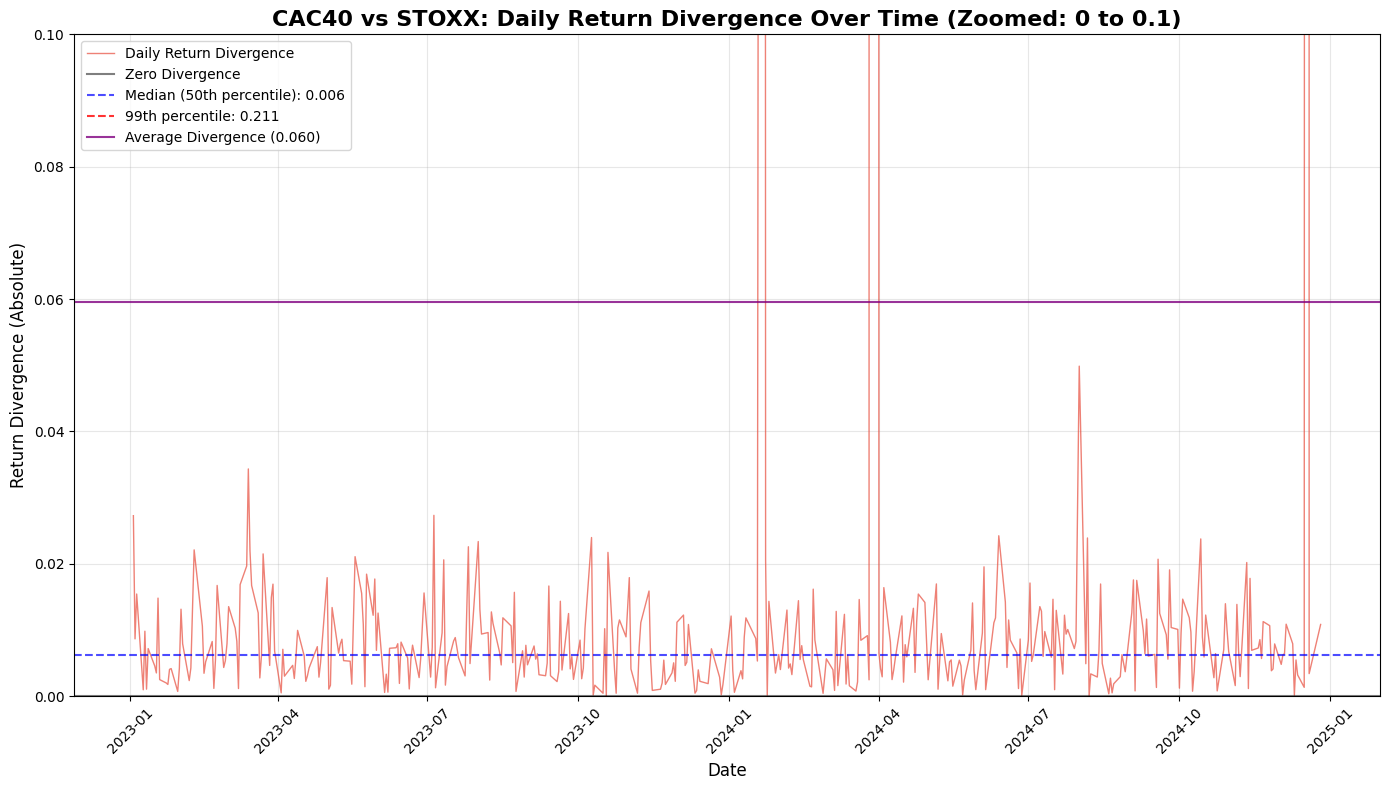


📊 DIVERGENCE SUMMARY STATISTICS:
Mean Divergence: 0.0596
Median Divergence: 0.0062
99th Percentile: 0.2108
Standard Deviation: 0.6547
Min Divergence: 0.0000
Max Divergence: 9.0301

📈 HIGH DIVERGENCE PERIODS (>99th percentile): 4 days
Date range: 2024-01-22 to 2024-12-18
High divergence days:
      Date  Return_Divergence  Close_CAC40  Close_STOXX
2024-01-22           0.896973   992.369995  4465.910156
2024-03-27           9.030087 10057.500000  5083.419922
2024-12-17           0.903090    99.987999  4957.279785
2024-12-18           9.024692  1000.770020  4879.000000

🎯 99TH PERCENTILE ANALYSIS:
The 99th percentile line (red dashed) shows the threshold for extreme divergence
Only 5% of days have divergence above this level
This helps identify the most significant market divergence events


In [9]:
print("=== CREATING DIVERGENCE OVER TIME GRAPH WITH 99TH PERCENTILE ===")

# Check if we have the merged data
if 'merged_df' in locals() and len(merged_df) > 0:
    # Create single graph for divergence over time
    plt.figure(figsize=(14, 8))
    
    # Return Divergence Over Time
    plt.plot(merged_df['Date'], merged_df['Return_Divergence'], 
             linewidth=1, color='#E74C3C', alpha=0.7, label='Daily Return Divergence')
    
    # Add reference lines
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Zero Divergence')
    
    # Calculate and show percentiles
    p50 = merged_df['Return_Divergence'].quantile(0.5)
    p99 = merged_df['Return_Divergence'].quantile(0.99)
    
    plt.axhline(y=p50, color='blue', linestyle='--', alpha=0.7, label=f'Median (50th percentile): {p50:.3f}')
    plt.axhline(y=p99, color='red', linestyle='--', alpha=0.8, label=f'99th percentile: {p99:.3f}')

    # Calculate and show average divergence
    avg_divergence = merged_df['Return_Divergence'].mean()
    plt.axhline(y=avg_divergence, color='purple', linestyle='-', alpha=0.8, 
               label=f'Average Divergence ({avg_divergence:.3f})')
    
    plt.title('CAC40 vs STOXX: Daily Return Divergence Over Time (Zoomed: 0 to 0.1)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Return Divergence (Absolute)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Set y-axis limits to zoom in between 0 and 0.1
    plt.ylim(0, 0.1)
    
    # Add some styling
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    divergence_data = merged_df['Return_Divergence'].dropna()
    print(f"\n📊 DIVERGENCE SUMMARY STATISTICS:")
    print(f"Mean Divergence: {divergence_data.mean():.4f}")
    print(f"Median Divergence: {divergence_data.median():.4f}")
    print(f"99th Percentile: {p99:.4f}")
    print(f"Standard Deviation: {divergence_data.std():.4f}")
    print(f"Min Divergence: {divergence_data.min():.4f}")
    print(f"Max Divergence: {divergence_data.max():.4f}")
    
    # Identify periods of high divergence
    high_div_periods = merged_df[merged_df['Return_Divergence'] > p99]
    
    print(f"\n📈 HIGH DIVERGENCE PERIODS (>99th percentile): {len(high_div_periods)} days") 
    if len(high_div_periods) > 0:
        print(f"Date range: {high_div_periods['Date'].min().date()} to {high_div_periods['Date'].max().date()}")
        print("High divergence days:")
        print(high_div_periods[['Date', 'Return_Divergence', 'Close_CAC40', 'Close_STOXX']].head(10).to_string(index=False))
        
    print(f"\n🎯 99TH PERCENTILE ANALYSIS:") 
    print(f"The 99th percentile line (red dashed) shows the threshold for extreme divergence") 
    print(f"Only 5% of days have divergence above this level")
    print(f"This helps identify the most significant market divergence events")
        
else:
    print("❌ No merged data available. Please run the STOXX comparison first.")


In [10]:
# Mark high divergence values (>99th percentile) as anomalies
print("=== MARKING HIGH DIVERGENCE VALUES AS ANOMALIES ===")

# Check if we have the merged data
if 'merged_df' in locals() and len(merged_df) > 0:
    # Calculate 99th percentile threshold
    p99_threshold = merged_df['Return_Divergence'].quantile(0.99)
    print(f"99th percentile threshold: {p99_threshold:.4f}")
    
    # Identify high divergence periods
    high_divergence_dates = merged_df[merged_df['Return_Divergence'] > p99_threshold]['Date']
    print(f"Found {len(high_divergence_dates)} days with extreme divergence (>99th percentile)")
    
    # Create anomaly flag for high divergence
    cac40_df['High_Divergence_Anomaly'] = cac40_df['Date'].isin(high_divergence_dates)
    
    # Show the high divergence anomalies
    high_div_anomalies = cac40_df[cac40_df['High_Divergence_Anomaly']][['Date', 'Close', 'Daily_Return', 'Volume', 'Volatility']]
    if len(high_div_anomalies) > 0:
        print(f"\n📈 HIGH DIVERGENCE ANOMALIES (>99th percentile):")
        print(high_div_anomalies.to_string(index=False))
        
        # Show the corresponding STOXX data for comparison
        print(f"\n📊 CORRESPONDING STOXX DATA:")
        for date in high_divergence_dates:
            sto_data = merged_df[merged_df['Date'] == date][['Date', 'Close_CAC40', 'Close_STOXX', 'Daily_Return_CAC40', 'Daily_Return_STOXX', 'Return_Divergence']]
            if len(sto_data) > 0:
                print(sto_data.to_string(index=False))
                print("---")
    else:
        print("No high divergence anomalies found.")
    
    # Update combined anomaly flag if it exists
    if 'Combined_Anomaly' in cac40_df.columns:
        cac40_df['Combined_Anomaly'] = cac40_df['Combined_Anomaly'] | cac40_df['High_Divergence_Anomaly']
        print(f"\n✅ Updated Combined_Anomaly flag to include high divergence anomalies")
    
    # Summary statistics
    total_high_div = cac40_df['High_Divergence_Anomaly'].sum()
    total_days = len(cac40_df)
    high_div_percentage = (total_high_div / total_days) * 100
    
    print(f"\n📊 HIGH DIVERGENCE ANOMALY SUMMARY:")
    print(f"Total High Divergence Anomalies: {total_high_div} out of {total_days} ({high_div_percentage:.2f}%)")
    print(f"99th Percentile Threshold: {p99_threshold:.4f}")
    
    # Show date range of high divergence anomalies
    if total_high_div > 0:
        anomaly_dates = cac40_df[cac40_df['High_Divergence_Anomaly']]['Date']
        print(f"Date Range: {anomaly_dates.min().date()} to {anomaly_dates.max().date()}")
        
        # Show the most extreme divergence
        max_divergence = merged_df['Return_Divergence'].max()
        max_div_date = merged_df[merged_df['Return_Divergence'] == max_divergence]['Date'].iloc[0]
        print(f"Most Extreme Divergence: {max_divergence:.4f} on {max_div_date.date()}")
    
    print(f"\n✅ High divergence anomalies successfully marked in CAC40 data!")
    
else:
    print("❌ No merged data available. Please run the STOXX comparison first.")

=== MARKING HIGH DIVERGENCE VALUES AS ANOMALIES ===
99th percentile threshold: 0.2108
Found 4 days with extreme divergence (>99th percentile)

📈 HIGH DIVERGENCE ANOMALIES (>99th percentile):
      Date        Close  Daily_Return   Volume  Volatility
2024-01-22   992.369995     -0.900189 722288.0    2.021671
2024-03-27 10057.500000      9.030417 527530.0    2.019203
2024-12-17    99.987999     -0.900116 591121.0    0.201210
2024-12-18  1000.770020      9.008902 304720.0    2.035068

📊 CORRESPONDING STOXX DATA:
      Date  Close_CAC40  Close_STOXX  Daily_Return_CAC40  Daily_Return_STOXX  Return_Divergence
2024-01-22   992.369995  4465.910156           -0.900189           -0.003216           0.896973
---
      Date  Close_CAC40  Close_STOXX  Daily_Return_CAC40  Daily_Return_STOXX  Return_Divergence
2024-03-27      10057.5  5083.419922            9.030417            0.000331           9.030087
---
      Date  Close_CAC40  Close_STOXX  Daily_Return_CAC40  Daily_Return_STOXX  Return_Divergen

## 8. Synthèse des Anomalies Détectées


In [11]:
# Fixed comprehensive anomaly summary with high divergence integration
print("=== FIXED COMPREHENSIVE ANOMALY SUMMARY WITH HIGH DIVERGENCE ===")

# Check which columns exist and create combined anomaly
anomaly_columns = []
if 'Return_Anomaly' in cac40_df.columns:
    anomaly_columns.append('Return_Anomaly')
if 'Return_IQR_Anomaly' in cac40_df.columns:
    anomaly_columns.append('Return_IQR_Anomaly')
if 'Return_Rolling_Anomaly' in cac40_df.columns:
    anomaly_columns.append('Return_Rolling_Anomaly')


# Create combined anomaly column
if len(anomaly_columns) > 0:
    cac40_df['Combined_Anomaly'] = cac40_df[anomaly_columns[0]]
    for col in anomaly_columns[1:]:
        cac40_df['Combined_Anomaly'] = cac40_df['Combined_Anomaly'] | cac40_df[col]
else:
    cac40_df['Combined_Anomaly'] = False


# Add high divergence anomalies if available
if 'High_Divergence_Anomaly' in cac40_df.columns:
    cac40_df['Combined_Anomaly'] = cac40_df['Combined_Anomaly'] | cac40_df['High_Divergence_Anomaly']
    print("✅ High divergence anomalies integrated")
else:
    print("⚠️  High divergence anomalies not found - run the high divergence detection first")

# Summary
total_anomalies = cac40_df['Combined_Anomaly'].sum()
total_days = len(cac40_df)
anomaly_percentage = (total_anomalies / total_days) * 100

print(f"\n📊 COMPREHENSIVE ANOMALY SUMMARY:")
print(f"Total Anomalous Days: {total_anomalies} out of {total_days} ({anomaly_percentage:.1f}%)")

# Breakdown by method
print(f"\nBreakdown by Method:")
if 'Return_Anomaly' in cac40_df.columns:
    print(f"- Z-Score (|Z| > 3): {cac40_df['Return_Anomaly'].sum()}")
if 'Return_IQR_Anomaly' in cac40_df.columns:
    print(f"- IQR Anomalies: {cac40_df['Return_IQR_Anomaly'].sum()}")
if 'Return_Rolling_Anomaly' in cac40_df.columns:
    print(f"- Rolling Deviation: {cac40_df['Return_Rolling_Anomaly'].sum()}")
if 'Vol_Spikes' in cac40_df.columns:
    print(f"- Volatility Spikes: {cac40_df['Vol_Spikes'].sum()}")
if 'High_Divergence_Anomaly' in cac40_df.columns:
    print(f"- High Divergence (>99th percentile): {cac40_df['High_Divergence_Anomaly'].sum()}")

# Show all combined anomalies
print(f"\nAll Combined Anomalies:")
all_anomalies = cac40_df[cac40_df['Combined_Anomaly']][['Date', 'Close', 'Daily_Return', 'Volume', 'Volatility']]
if len(all_anomalies) > 0:
    print(all_anomalies.to_string(index=False))
else:
    print("No combined anomalies found.")

print("✅ Fixed comprehensive anomaly analysis with high divergence integration completed!")

=== FIXED COMPREHENSIVE ANOMALY SUMMARY WITH HIGH DIVERGENCE ===
✅ High divergence anomalies integrated

📊 COMPREHENSIVE ANOMALY SUMMARY:
Total Anomalous Days: 9 out of 488 (1.8%)

Breakdown by Method:
- Z-Score (|Z| > 3): 4
- IQR Anomalies: 9
- Rolling Deviation: 4
- High Divergence (>99th percentile): 4

All Combined Anomalies:
      Date        Close  Daily_Return   Volume  Volatility
2023-02-09   999.469971      0.009821 903806.0    0.003839
2023-04-28   987.169983     -0.008238 869460.0    0.003052
2024-01-19  9942.500000      8.948768 498237.0    2.000990
2024-01-22   992.369995     -0.900189 722288.0    2.021671
2024-03-27 10057.500000      9.030417 527530.0    2.019203
2024-03-28   100.635002     -0.989994 541441.0    2.042835
2024-03-29  1005.909973      8.995627 969446.0    2.799698
2024-12-17    99.987999     -0.900116 591121.0    0.201210
2024-12-18  1000.770020      9.008902 304720.0    2.035068
✅ Fixed comprehensive anomaly analysis with high divergence integration comple

In [12]:
# Enhanced anomaly display with method flags
print("=== ENHANCED ANOMALY DISPLAY WITH METHOD FLAGS ===")

# Get all anomalies
all_anomalies = cac40_df[cac40_df['Combined_Anomaly']].copy()

if len(all_anomalies) > 0:
    # Create a column showing which methods flagged each anomaly
    def get_anomaly_methods(row):
        methods = []
        if 'Return_Anomaly' in cac40_df.columns and row['Return_Anomaly']:
            methods.append('Z-Score')
        if 'Return_IQR_Anomaly' in cac40_df.columns and row['Return_IQR_Anomaly']:
            methods.append('IQR')
        if 'Return_Rolling_Anomaly' in cac40_df.columns and row['Return_Rolling_Anomaly']:
            methods.append('Rolling')
        if 'Vol_Spikes' in cac40_df.columns and row['Vol_Spikes']:
            methods.append('Volatility')
        if 'High_Divergence_Anomaly' in cac40_df.columns and row['High_Divergence_Anomaly']:
            methods.append('High-Divergence')
        return ', '.join(methods)
    
    all_anomalies['Anomaly_Methods'] = all_anomalies.apply(get_anomaly_methods, axis=1)
    
    # Display anomalies with method information
    display_columns = ['Date', 'Close', 'Daily_Return', 'Volume', 'Volatility', 'Anomaly_Methods']
    print(f"\n📊 ALL ANOMALIES WITH DETECTION METHODS:")
    print(all_anomalies[display_columns].to_string(index=False))
    
    # Summary of anomaly methods
    print(f"\n📈 ANOMALY METHOD SUMMARY:")
    method_counts = {}
    for methods in all_anomalies['Anomaly_Methods']:
        for method in methods.split(', '):
            method_counts[method] = method_counts.get(method, 0) + 1
    
    for method, count in sorted(method_counts.items()):
        print(f"- {method}: {count} anomalies")
        
    # Show anomalies detected by multiple methods
    multi_method_anomalies = all_anomalies[all_anomalies['Anomaly_Methods'].str.contains(',')]
    if len(multi_method_anomalies) > 0:
        print(f"\n🔍 ANOMALIES DETECTED BY MULTIPLE METHODS ({len(multi_method_anomalies)}):")
        print(multi_method_anomalies[display_columns].to_string(index=False))
    
    # Show anomalies detected by only one method
    single_method_anomalies = all_anomalies[~all_anomalies['Anomaly_Methods'].str.contains(',')]
    if len(single_method_anomalies) > 0:
        print(f"\n🎯 ANOMALIES DETECTED BY SINGLE METHOD ({len(single_method_anomalies)}):")
        print(single_method_anomalies[display_columns].to_string(index=False))
    
else:
    print("No combined anomalies found.")

print("✅ Enhanced anomaly display with method flags completed!")

=== ENHANCED ANOMALY DISPLAY WITH METHOD FLAGS ===

📊 ALL ANOMALIES WITH DETECTION METHODS:
      Date        Close  Daily_Return   Volume  Volatility                        Anomaly_Methods
2023-02-09   999.469971      0.009821 903806.0    0.003839                                    IQR
2023-04-28   987.169983     -0.008238 869460.0    0.003052                                    IQR
2024-01-19  9942.500000      8.948768 498237.0    2.000990                  Z-Score, IQR, Rolling
2024-01-22   992.369995     -0.900189 722288.0    2.021671                   IQR, High-Divergence
2024-03-27 10057.500000      9.030417 527530.0    2.019203 Z-Score, IQR, Rolling, High-Divergence
2024-03-28   100.635002     -0.989994 541441.0    2.042835                                    IQR
2024-03-29  1005.909973      8.995627 969446.0    2.799698                           Z-Score, IQR
2024-12-17    99.987999     -0.900116 591121.0    0.201210          IQR, Rolling, High-Divergence
2024-12-18  1000.770020   

### Graphique avec les anomalies en évidence

=== CREATING ANOMALY HIGHLIGHTING GRAPH ===


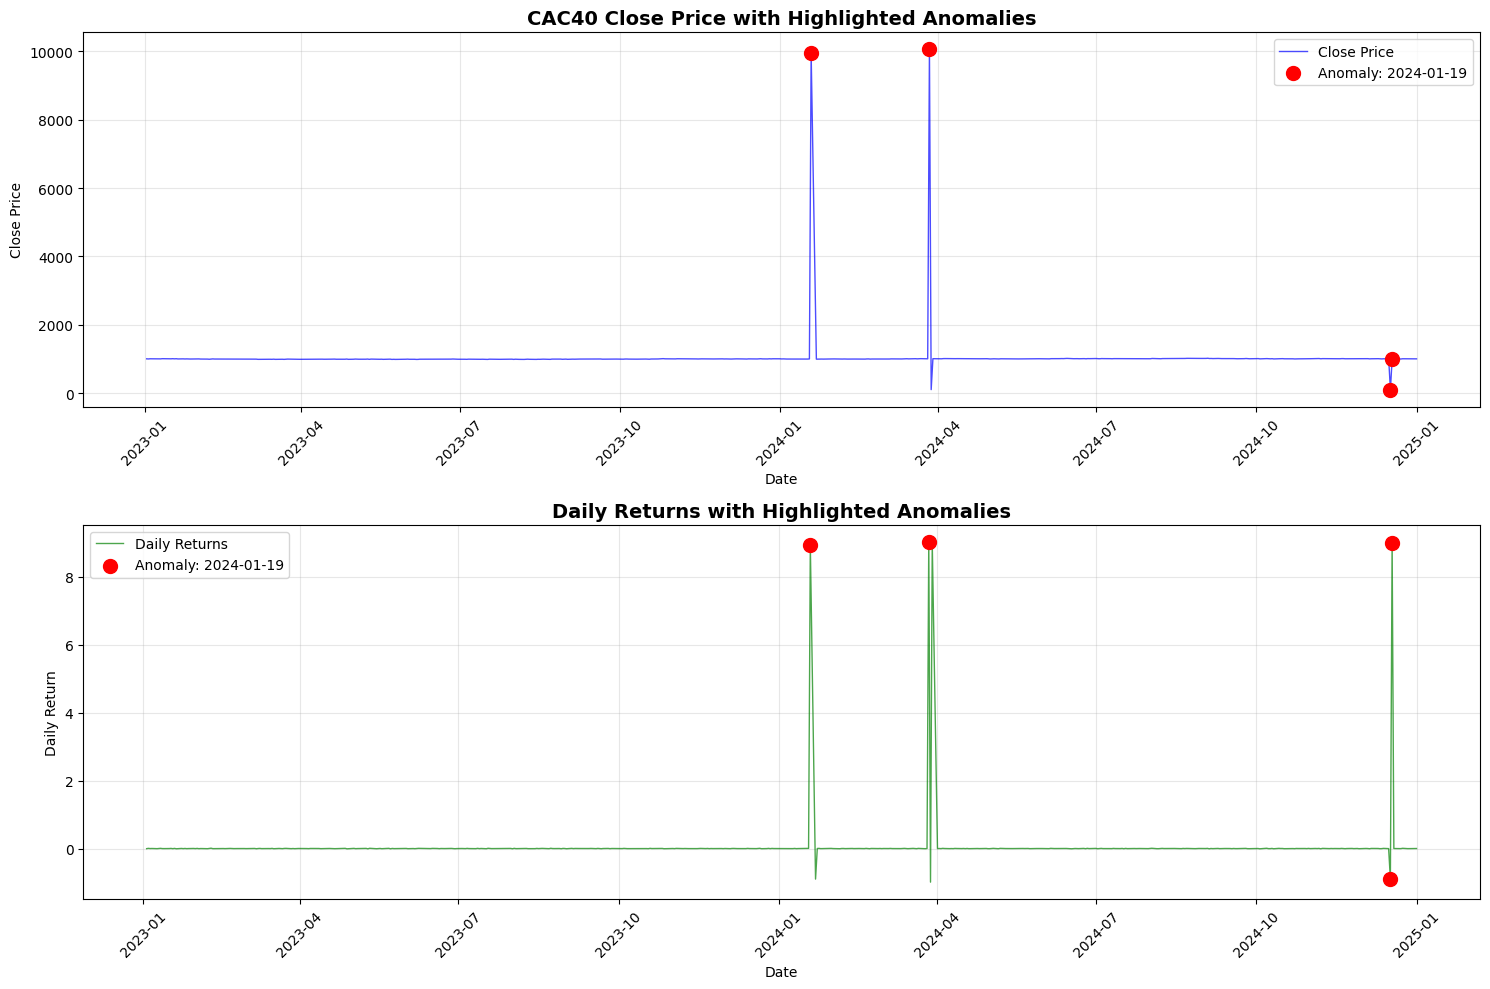


🔍 DETAILED ANALYSIS OF HIGHLIGHTED ANOMALIES:

📅 2024-01-19:
  Close Price: 9942.50
  Daily Return: 8.9488 (894.88%)
  Return Z-Score: 10.8756
  Volume: 498,237
  Volume Z-Score: -0.2480
  Anomaly Types: Return Anomaly, Close Price Anomaly

📅 2024-03-27:
  Close Price: 10057.50
  Daily Return: 9.0304 (903.04%)
  Return Z-Score: 10.9756
  Volume: 527,530
  Volume Z-Score: -0.1307
  Anomaly Types: Return Anomaly, Close Price Anomaly, High Divergence Anomaly

📅 2024-12-17:
  Close Price: 99.99
  Daily Return: -0.9001 (-90.01%)
  Return Z-Score: -1.1858
  Volume: 591,121
  Volume Z-Score: 0.1241
  Anomaly Types: High Divergence Anomaly

📅 2024-12-18:
  Close Price: 1000.77
  Daily Return: 9.0089 (900.89%)
  Return Z-Score: 10.9492
  Volume: 304,720
  Volume Z-Score: -1.0234
  Anomaly Types: Return Anomaly, High Divergence Anomaly

✅ Anomaly highlighting graph completed successfully!


In [13]:
# Create anomaly highlighting graph for specific dates
print("=== CREATING ANOMALY HIGHLIGHTING GRAPH ===")

# Check if we have the required data
if 'cac40_df' in locals() and len(cac40_df) > 0:
    # Convert Date column to datetime if it's not already
    cac40_df['Date'] = pd.to_datetime(cac40_df['Date'])
    
    # Define the specific anomaly dates to highlight
    highlight_dates = ['2024-01-19', '2024-03-27', '2024-12-17', '2024-12-18']
    highlight_dates_dt = [pd.to_datetime(date) for date in highlight_dates]
    
    # Create the graph
    plt.figure(figsize=(15, 10))
    
    # Plot the close price
    plt.subplot(2, 1, 1)
    plt.plot(cac40_df['Date'], cac40_df['Close'], linewidth=1, color='blue', alpha=0.7, label='Close Price')
    
    # Highlight the specific anomaly dates
    for date in highlight_dates_dt:
        if date in cac40_df['Date'].values:
            close_value = cac40_df[cac40_df['Date'] == date]['Close'].iloc[0]
            plt.scatter(date, close_value, color='red', s=100, zorder=5, 
                       label=f'Anomaly: {date.strftime("%Y-%m-%d")}' if date == highlight_dates_dt[0] else "")
    
    plt.title('CAC40 Close Price with Highlighted Anomalies', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot daily returns
    plt.subplot(2, 1, 2)
    plt.plot(cac40_df['Date'], cac40_df['Daily_Return'], linewidth=1, color='green', alpha=0.7, label='Daily Returns')
    
    # Highlight the specific anomaly dates
    for date in highlight_dates_dt:
        if date in cac40_df['Date'].values:
            return_value = cac40_df[cac40_df['Date'] == date]['Daily_Return'].iloc[0]
            plt.scatter(date, return_value, color='red', s=100, zorder=5, 
                       label=f'Anomaly: {date.strftime("%Y-%m-%d")}' if date == highlight_dates_dt[0] else "")
    
    plt.title('Daily Returns with Highlighted Anomalies', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed information about the highlighted anomalies
    print(f"\n🔍 DETAILED ANALYSIS OF HIGHLIGHTED ANOMALIES:")
    print("=" * 60)
    
    for date_str in highlight_dates:
        date_dt = pd.to_datetime(date_str)
        if date_dt in cac40_df['Date'].values:
            row = cac40_df[cac40_df['Date'] == date_dt].iloc[0]
            print(f"\n📅 {date_str}:")
            print(f"  Close Price: {row['Close']:.2f}")
            print(f"  Daily Return: {row['Daily_Return']:.4f} ({row['Daily_Return']*100:.2f}%)")
            if 'Return_ZScore' in cac40_df.columns:
                print(f"  Return Z-Score: {row['Return_ZScore']:.4f}")
            if 'Volume' in cac40_df.columns:
                print(f"  Volume: {row['Volume']:,.0f}")
            if 'Volume_ZScore' in cac40_df.columns:
                print(f"  Volume Z-Score: {row['Volume_ZScore']:.4f}")
            
            # Check which anomaly types were triggered
            anomaly_types = []
            if 'Return_Anomaly' in cac40_df.columns and row['Return_Anomaly']:
                anomaly_types.append('Return Anomaly')
            if 'Volume_Anomaly' in cac40_df.columns and row['Volume_Anomaly']:
                anomaly_types.append('Volume Anomaly')
            if 'Close_Anomaly' in cac40_df.columns and row['Close_Anomaly']:
                anomaly_types.append('Close Price Anomaly')
            if 'High_Divergence_Anomaly' in cac40_df.columns and row['High_Divergence_Anomaly']:
                anomaly_types.append('High Divergence Anomaly')
            if 'CAC40_Specific_Anomaly' in cac40_df.columns and row['CAC40_Specific_Anomaly']:
                anomaly_types.append('CAC40-Specific Anomaly')
            
            if anomaly_types:
                print(f"  Anomaly Types: {', '.join(anomaly_types)}")
            else:
                print(f"  Anomaly Types: None detected")
        else:
            print(f"\n❌ Date {date_str} not found in dataset")
    
    print(f"\n✅ Anomaly highlighting graph completed successfully!")
    
else:
    print("❌ No CAC40 data available. Please run the data loading and anomaly detection first.")

### Analyse visuelle de base via graphiques avec les anomalies supprimées

=== CREATING GRAPHS WITH ANOMALIES DELETED ===
Original data: 488 rows
Clean data (anomalies removed): 479 rows
Anomalies removed: 9 rows


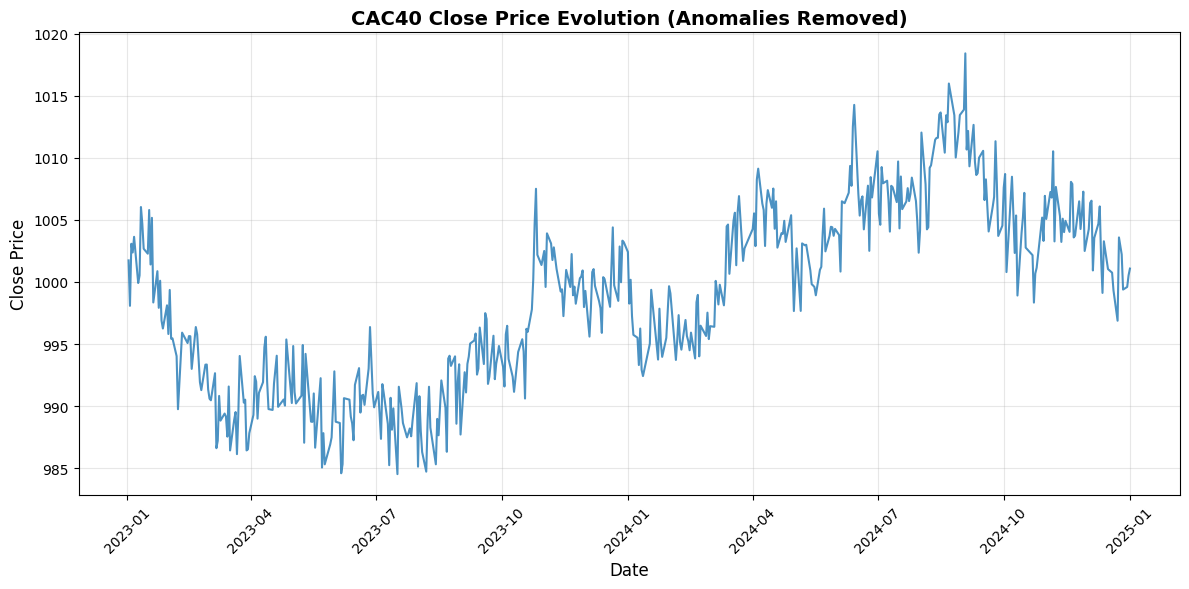

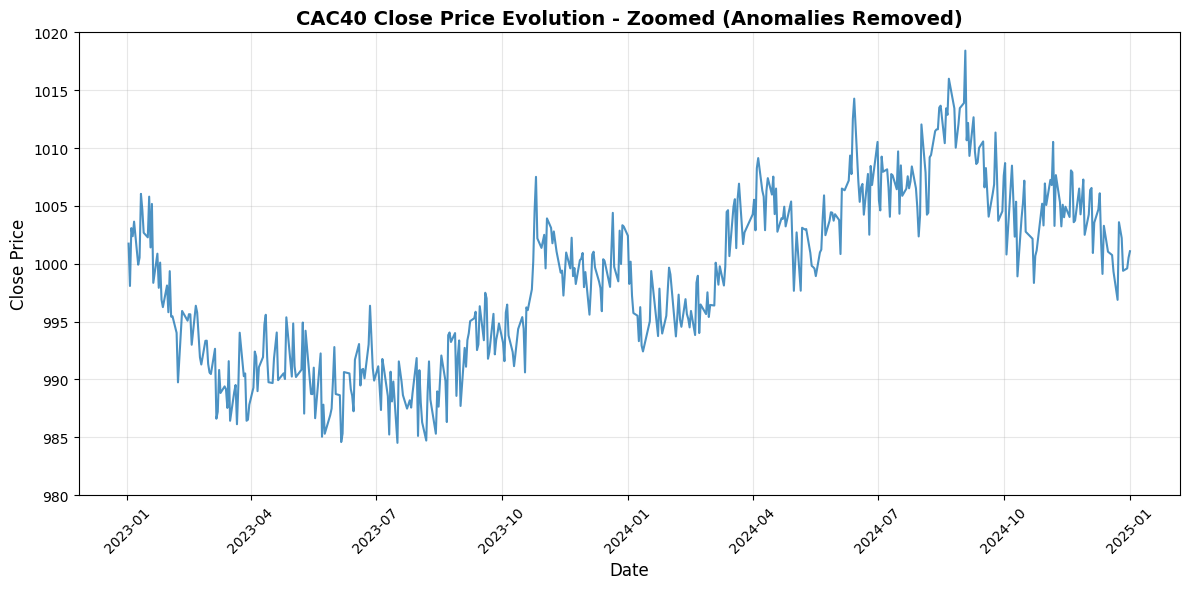

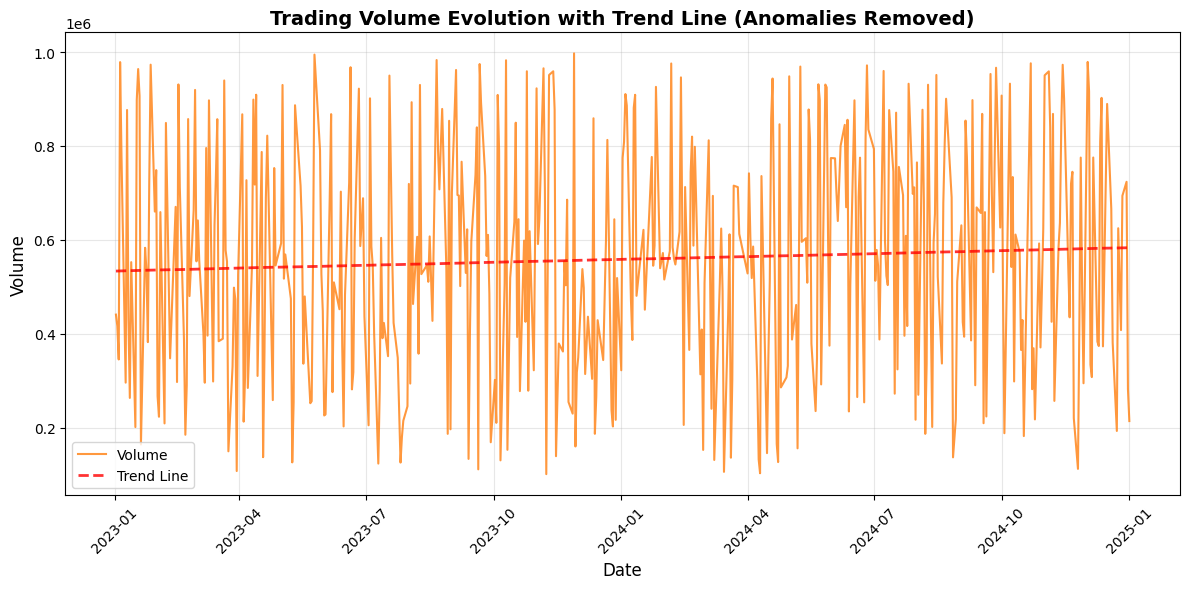

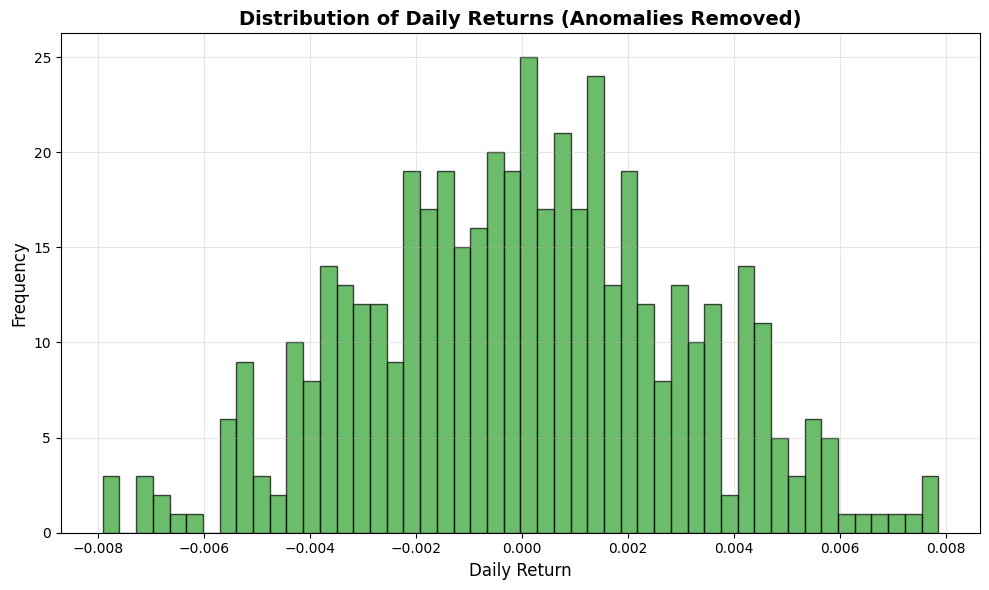

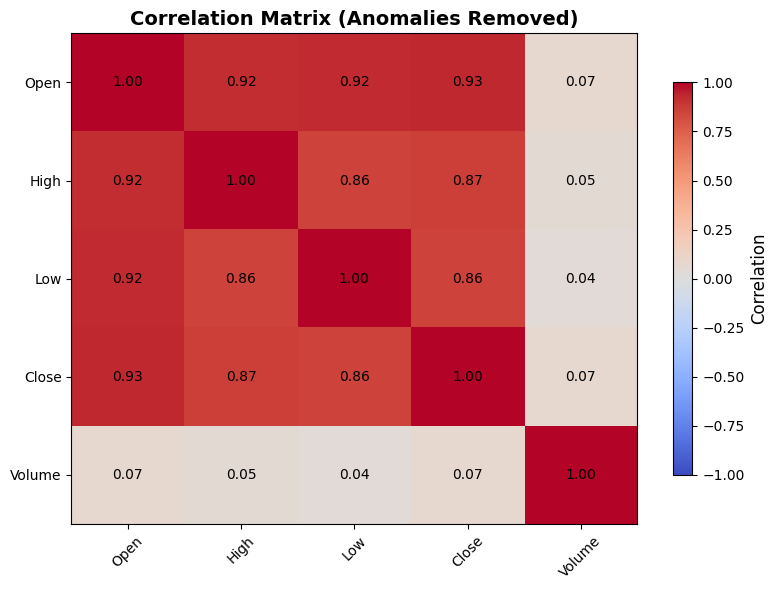


=== Basic Statistics (Anomalies Removed) ===
Date range: 2023-01-02 to 2025-01-01
Total trading days: 479
Average daily return: 0.0000
Daily return volatility (std): 0.0030
Min daily return: -0.0079
Max daily return: 0.0078

=== COMPARISON: Original vs Clean Data ===
Data points removed: 9 (1.84%)

Daily Returns Comparison:
Original - Mean: 0.0682, Std: 0.8166
Clean    - Mean: 0.0000, Std: 0.0030
Difference - Mean: -0.0682, Std: -0.8136

✅ Clean data analysis completed successfully!


In [14]:
# Create the same graphs but with anomalies deleted
print("=== CREATING GRAPHS WITH ANOMALIES DELETED ===")

# Check if we have anomaly detection results
if 'cac40_df' in locals() and 'Combined_Anomaly' in cac40_df.columns:
    # Create a copy of the data without anomalies
    cac40_clean = cac40_df[~cac40_df['Combined_Anomaly']].copy()
    print(f"Original data: {len(cac40_df)} rows")
    print(f"Clean data (anomalies removed): {len(cac40_clean)} rows")
    print(f"Anomalies removed: {len(cac40_df) - len(cac40_clean)} rows")
    
    # Set up the plotting style
    plt.style.use('default')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # 1. Close price evolution over time (CLEAN DATA)
    plt.figure(figsize=(12, 6))
    plt.plot(cac40_clean['Date'], cac40_clean['Close'], linewidth=1.5, alpha=0.8, color=colors[0])
    plt.title('CAC40 Close Price Evolution (Anomalies Removed)', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 1b. Close price evolution - ZOOMED VERSION (CLEAN DATA)
    plt.figure(figsize=(12, 6))
    plt.plot(cac40_clean['Date'], cac40_clean['Close'], linewidth=1.5, alpha=0.8, color=colors[0])
    plt.title('CAC40 Close Price Evolution - Zoomed (Anomalies Removed)', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.ylim(980, 1020)  # Zoom between 980 and 1020
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Volume over time with trend line (CLEAN DATA)
    plt.figure(figsize=(12, 6))
    plt.plot(cac40_clean['Date'], cac40_clean['Volume'], linewidth=1.5, alpha=0.8, color=colors[1], label='Volume')
    plt.title('Trading Volume Evolution with Trend Line (Anomalies Removed)', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volume', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add trend line using manual linear regression
    import numpy as np
    
    # Convert dates to numeric values for regression
    date_numeric = np.arange(len(cac40_clean))
    volume_values = cac40_clean['Volume'].values
    
    # Manual linear regression calculation
    n = len(date_numeric)
    sum_x = np.sum(date_numeric)
    sum_y = np.sum(volume_values)
    sum_xy = np.sum(date_numeric * volume_values)
    sum_x2 = np.sum(date_numeric ** 2)
    
    # Calculate slope and intercept
    slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    intercept = (sum_y - slope * sum_x) / n
    
    # Calculate trend line
    trend_line = slope * date_numeric + intercept
    
    # Plot trend line
    plt.plot(cac40_clean['Date'], trend_line, '--', linewidth=2, color='red', alpha=0.8, label='Trend Line')
    
    # Add legend
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3. Daily returns distribution (CLEAN DATA)
    daily_returns_clean = cac40_clean['Close'].pct_change().dropna()
    plt.figure(figsize=(10, 6))
    plt.hist(daily_returns_clean, bins=50, alpha=0.7, edgecolor='black', color=colors[2])
    plt.title('Distribution of Daily Returns (Anomalies Removed)', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Return', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Correlation heatmap (CLEAN DATA)
    correlation_data_clean = cac40_clean[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
    plt.figure(figsize=(8, 6))
    im = plt.imshow(correlation_data_clean, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.title('Correlation Matrix (Anomalies Removed)', fontsize=14, fontweight='bold')
    plt.xticks(range(len(correlation_data_clean.columns)), correlation_data_clean.columns, rotation=45)
    plt.yticks(range(len(correlation_data_clean.columns)), correlation_data_clean.columns)
    
    # Add correlation values as text
    for i in range(len(correlation_data_clean.columns)):
        for j in range(len(correlation_data_clean.columns)):
            text = plt.text(j, i, f'{correlation_data_clean.iloc[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('Correlation', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print basic statistics for clean data
    print("\n=== Basic Statistics (Anomalies Removed) ===")
    print(f"Date range: {cac40_clean['Date'].min().strftime('%Y-%m-%d')} to {cac40_clean['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Total trading days: {len(cac40_clean)}")
    print(f"Average daily return: {daily_returns_clean.mean():.4f}")
    print(f"Daily return volatility (std): {daily_returns_clean.std():.4f}")
    print(f"Min daily return: {daily_returns_clean.min():.4f}")
    print(f"Max daily return: {daily_returns_clean.max():.4f}")
    
    # Compare statistics with and without anomalies
    print("\n=== COMPARISON: Original vs Clean Data ===")
    print(f"Data points removed: {len(cac40_df) - len(cac40_clean)} ({(len(cac40_df) - len(cac40_clean))/len(cac40_df)*100:.2f}%)")
    
    # Compare daily returns statistics
    daily_returns_original = cac40_df['Close'].pct_change().dropna()
    print(f"\nDaily Returns Comparison:")
    print(f"Original - Mean: {daily_returns_original.mean():.4f}, Std: {daily_returns_original.std():.4f}")
    print(f"Clean    - Mean: {daily_returns_clean.mean():.4f}, Std: {daily_returns_clean.std():.4f}")
    print(f"Difference - Mean: {daily_returns_clean.mean() - daily_returns_original.mean():.4f}, Std: {daily_returns_clean.std() - daily_returns_original.std():.4f}")
    
    print(f"\n✅ Clean data analysis completed successfully!")
    
else:
    print("❌ No anomaly detection results available. Please run anomaly detection first.")
    print("Available columns:", list(cac40_df.columns) if 'cac40_df' in locals() else "No data loaded")

## 9. Export des données sans anomalies

In [18]:
# Export clean data (without anomalies) to parquet file - SELECTED COLUMNS
print("=== EXPORTING CLEAN DATA TO PARQUET FILE (SELECTED COLUMNS) ===")

# Check if we have the clean data
if 'cac40_clean' in locals() and len(cac40_clean) > 0:
    # Prepare the clean data for export
    # Export only specific columns: Date, Open, High, Low, Close, Volume, Daily_Return
    selected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']
    
    # Check which columns exist in the clean data
    available_columns = [col for col in selected_columns if col in cac40_clean.columns]
    print(f"Requested columns: {selected_columns}")
    print(f"Available columns: {available_columns}")
    
    if len(available_columns) > 0:
        # Create export dataframe with only selected columns
        export_df = cac40_clean[available_columns].copy()
    
    # Sort by date to ensure proper order
    export_df = export_df.sort_values('Date').reset_index(drop=True)
    
    # Export to parquet file
    output_filename = 'cac40_clean_no_anomalies.parquet'
    export_df.to_parquet(output_filename, index=False)
    
    print(f"✅ Clean data exported successfully!")
    print(f"📁 File: {output_filename}")
    print(f"📊 Shape: {export_df.shape[0]} rows, {export_df.shape[1]} columns")
    print(f"📅 Date range: {export_df['Date'].min().strftime('%Y-%m-%d')} to {export_df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"🗑️  Anomalies removed: {len(cac40_df) - len(export_df)} rows ({(len(cac40_df) - len(export_df))/len(cac40_df)*100:.2f}%)")
    
    # Show first few rows of exported data
    print(f"\n📋 First 5 rows of exported data:")
    print(export_df.head().to_string(index=False))
    
    # Show last few rows of exported data
    print(f"\n📋 Last 5 rows of exported data:")
    print(export_df.tail().to_string(index=False))
    
    # Basic statistics of exported data
    print(f"\n📈 Basic Statistics of Exported Data:")
    print(f"Average Close Price: {export_df['Close'].mean():.2f}")
    print(f"Min Close Price: {export_df['Close'].min():.2f}")
    print(f"Max Close Price: {export_df['Close'].max():.2f}")
    print(f"Average Volume: {export_df['Volume'].mean():,.0f}")
    
    # Show all columns that were exported
    print(f"\n📋 Exported columns:")
    for i, col in enumerate(export_df.columns, 1):
        print(f"{i:2d}. {col}")
        
    else:
        print("❌ No selected columns found in clean data")
        print(f"Available columns in clean data: {list(cac40_clean.columns)}")
        
else:
    print("❌ No clean data available. Please run the anomaly detection and cleaning first.")
    if 'cac40_df' in locals():
        print(f"Original data available: {len(cac40_df)} rows")
        print("Available columns:", list(cac40_df.columns))
    else:
        print("No data loaded.")

print(f"\n🎯 Export completed! The file 'cac40_clean_no_anomalies.parquet' contains the CAC40 data with all anomalies removed and selected columns: Date, Open, High, Low, Close, Volume, Daily_Return.")


=== EXPORTING CLEAN DATA TO PARQUET FILE (SELECTED COLUMNS) ===
Requested columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']
Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']
✅ Clean data exported successfully!
📁 File: cac40_clean_no_anomalies.parquet
📊 Shape: 479 rows, 7 columns
📅 Date range: 2023-01-02 to 2025-01-01
🗑️  Anomalies removed: 9 rows (1.84%)

📋 First 5 rows of exported data:
      Date        Open        High        Low       Close   Volume  Daily_Return
2023-01-02 1001.640015 1004.900024 998.989990 1001.739990 440686.0           NaN
2023-01-03  998.830017 1006.710022 994.859985  998.080017 416463.0     -0.003654
2023-01-04  997.400024 1004.780029 991.119995 1003.080017 345144.0      0.005010
2023-01-05  999.270020 1006.169983 997.809998 1002.380005 978499.0     -0.000698
2023-01-06 1002.390015 1005.520020 995.609985 1003.640015 776999.0      0.001257

📋 Last 5 rows of exported data:
      Date        Open      